## Set Up

In [1]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import seaborn as sns
import watermark

In [2]:
# set plotting theme
sns.set_theme(style="whitegrid", context="paper")

In [3]:
# load raw data
raw_df = pd.read_csv('../data/raw/rawdata_new.csv')
# create copy of raw data
processed_df = raw_df.copy()

## Data Prep

### Add predictors

In [4]:
# remove columns with NA
processed_df.dropna(axis=1, inplace=True)

# drop ID
processed_df.drop(['id'], axis=1, inplace=True)

# convert date to numeric; use days since March 1, since paper says survey began in March
processed_df['date'] = pd.to_datetime(processed_df['date'])
processed_df['date_diff'] = (processed_df['date'] - pd.to_datetime('March 1, 2019'))
processed_df['days_since_first_survey_completed'] = [d.days for d in processed_df['date_diff']]

# drop intermediate date columns
processed_df.drop(['date', 'date_diff'], axis=1, inplace=True)

### Add outcome variable

In [5]:
# calculate outcome variable
implemented_cols = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'biog', 'ecodr']
processed_df['num_implemented'] = (processed_df[implemented_cols] == 1).sum(axis=1)
processed_df['num_applicable'] = (processed_df[implemented_cols] != 3).sum(axis=1)
processed_df['prop_implemented'] = processed_df['num_implemented'] / processed_df['num_applicable']

In [6]:
# remove other columns about implemented measures
processed_df.drop(implemented_cols, axis=1, inplace=True)
processed_df.drop(['num_implemented', 'num_applicable'], axis=1, inplace=True)

### Write to CSV

In [7]:
# write dataset to CSV
processed_df.to_csv('../data/processed/ebm_data.csv')

## Split dataset

In [8]:
# load libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error

# set random seed
RANDOM_SEED = 2021

In [9]:
# split into predictors and outcome
X = processed_df.iloc[:,:-1].to_numpy()
y = processed_df.iloc[:,-1].to_numpy()

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

## Encode categorical feature

In [11]:
# encode categorical variable region at column 22 into numeric
encoder = OrdinalEncoder()
encoder.fit(X_train[:,22].reshape(-1,1))
X_train[:,22] = encoder.transform(X_train[:,22].reshape(-1,1)).reshape(-1)
X_test[:,22]  = encoder.transform(X_test[:,22].reshape(-1,1)).reshape(-1)

## Add feature names back to X

In [12]:
# add feature names back to X after splitting, encoding, and normalizing data
X_train = pd.DataFrame(X_train, columns = processed_df.columns[:-1])
X_test  = pd.DataFrame(X_test, columns = processed_df.columns[:-1])

## Train regressor

In [13]:
# train regressor
ebm = ExplainableBoostingRegressor(random_state=RANDOM_SEED)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['trees', 'arable_land', 'ley',
                                            'perm_grass', 'perm_crops',
                                            'prot_cult', 'add_agr_land',
                                            'oth_land', 'qual_landscape',
                                            'spec_crops', 'grapes',
                                            'vegetables', 'fruits',
                                            'oth_spec_crops', 'animal_unit',
                                            'cattle_animal_unit', 'dairy_cows',
                                            'suckler_cows', 'hor_shee_goa',
                                            'pigs_poultry', 'pigs', 'poultry',
                                            'region', 'educ', 'cons_gene...
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                      

In [14]:
# get predictions for training and test set
y_train_pred = ebm.predict(X_train)
y_test_pred  = ebm.predict(X_test)

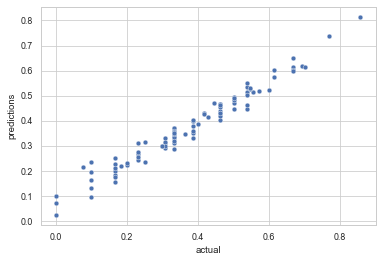

In [15]:
# plot predictions vs. actual for training set
sns.scatterplot(
    data=pd.DataFrame({'actual':y_train, 'predictions':y_train_pred}),
    x='actual',
    y='predictions')
plt.savefig('../figures/ebm_train_actual_vs_predictions.png', dpi=300)

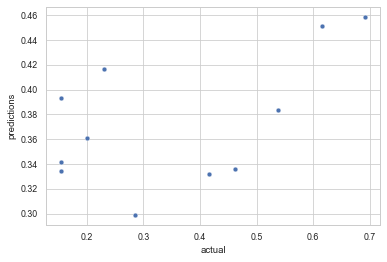

In [16]:
# plot predictions vs. actual for test set
sns.scatterplot(
    data=pd.DataFrame({'actual':y_test, 'predictions':y_test_pred}),
    x='actual',
    y='predictions')
plt.savefig('../figures/ebm_test_actual_vs_predictions.png', dpi=300)

In [17]:
# evaluate R-squared for training and test data
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test,  y_test_pred)
print(f'train: {r2_train} | test: {r2_test}')

train: 0.9391913013794313 | test: 0.20569869329331658


In [18]:
# evaluate mean squared error for training and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test,  y_test_pred)
print(f'train: {mse_train} | test: {mse_test}')

train: 0.001960972480184802 | test: 0.028597357393952163


In [19]:
# explore feature importance
ebm_global = ebm.explain_global()
show(ebm_global)

# save feature importance plot manually

/opt/anaconda3/lib/python3.7/site-packages/interpret/visual/udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/opt/anaconda3/lib/python3.7/site-packages/interpret/visual/udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/opt/anaconda3/lib/python3.7/site-packages/interpret/visual/udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7231/140273280676816/ -->

# Version details

In [20]:
%load_ext watermark
%watermark

Last updated: 2021-12-15T18:17:06.787918-08:00

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.19.0

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



In [21]:
%watermark -iv

matplotlib: 3.3.2
seaborn   : 0.11.1
watermark : 2.2.0
pandas    : 1.2.0
sys       : 3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

